## Base Code

### Prerequisites

Python 3.6+ is required because of certain performance optimization steps, such as the use of f-strings.  
GPU usage is required, e.g. the LSTM layers are specific CuDNN ones.

In [26]:
### Parameters ###
%tensorflow_version 1.x  # Set the tensorflow version
use_google_drive = True #@param {type:"boolean"}
gpu_fraction_usage = 0.9 #@param {type:"slider", min:0, max:1, step:0.1}
###            ###

# Upgrade gensim package
!pip install gensim --upgrade --quiet

# Connect to Google Drive via the bundled client which is the simplest out of many approaches
if use_google_drive == True:
    from google.colab import drive
    drive.mount('/content/gdrive')

# GPU usage settings for Tensorflow backend
from tensorflow import ConfigProto, Session
from keras import backend as K
if K.backend() == "tensorflow":
    from keras.backend.tensorflow_backend import set_session
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction_usage
    set_session(Session(config=config))
else:
    raise ValueError("Keras is not using the 'tensorflow' backend")

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  # Set the tensorflow version`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Preprocessing

In [28]:
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, CuDNNLSTM, Bidirectional, Dropout 
from keras.layers import SimpleRNN, GRU, GlobalAveragePooling1D, Conv1D, Flatten
from keras.layers import BatchNormalization
from keras.optimizers import Adam, SGD, Adagrad
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model, np_utils
from gensim.models import Word2Vec, KeyedVectors
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
###            ###
import numpy as np
import pandas as pd
import time
import math
import os
import matplotlib.pyplot as plt
###            ###
import random
from tensorflow import set_random_seed

### Parameters ###
random_state = 22 #@param {type:"slider", min:0, max:100, step:1}
dataset_name = "SemEval-2017 Task 4" #@param ["IMDb Large Movie Review Dataset", "Movie Review Subjectivity Dataset", "Movie Review Polarity Dataset", "SCH Dataset", "Finegrained Sentiment Dataset", "SemEval-2017 Task 4"]
feature_count = 15000 #@param {type:"slider", min:0, max:140000, step:5000}
###            ###

# Reproducibility
random.seed(random_state)  # Python's seed
np.random.seed(random_state)  # Numpy's seed
set_random_seed(random_state)  # Tensorflow's seed

def load_dataset():
    ''' Dataset Loading '''
    if dataset_name == "IMDb Large Movie Review Dataset":
        (train_data, train_labels), (test_data, test_labels) = imdb.load_data(seed=random_state, num_words=feature_count)

    elif dataset_name == "Movie Review Subjectivity Dataset":
        data = ["" for i in range(10000)]
        labels = ["" for i in range(10000)]
        count = 0
        with open('./gdrive/My Drive/Colab Datasets/Movie Review Subjectivity Dataset/plot.tok.gt9.5000', 'r', encoding='iso-8859-15') as file:
            for line in file:
                data[count] = line.rstrip('\n')
                labels[count] = 0
                count += 1
        with open('./gdrive/My Drive/Colab Datasets/Movie Review Subjectivity Dataset/quote.tok.gt9.5000', 'r', encoding='iso-8859-15') as file:
            for line in file:
                data[count] = line.rstrip('\n')
                labels[count] = 1
                count += 1   
        train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, random_state=random_state, shuffle=True)   
        del data, labels

    elif dataset_name == "Movie Review Polarity Dataset":
        data = ["" for i in range(10662)]
        labels = ["" for i in range(10662)]
        count = 0
        with open('./gdrive/My Drive/Colab Datasets/Movie Review Polarity Dataset/rt-polarity.neg', 'r', encoding='iso-8859-15') as file:
            for line in file:
                data[count] = line.rstrip('\n')
                labels[count] = 0
                count += 1
        with open('./gdrive/My Drive/Colab Datasets/Movie Review Polarity Dataset/rt-polarity.pos', 'r', encoding='iso-8859-15') as file:
            for line in file:
                data[count] = line.rstrip('\n')
                labels[count] = 1
                count += 1    
        train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, random_state=random_state, shuffle=True)  

    elif dataset_name == "SCH Dataset":
        df1 = pd.read_csv('./gdrive/My Drive/Colab Datasets/SCH Dataset/final_data_q13.csv', delimiter="|", header=None)
        df2 = pd.read_csv('./gdrive/My Drive/Colab Datasets/SCH Dataset/final_data_q14.csv', delimiter="|", header=None)
        df3 = pd.read_csv('./gdrive/My Drive/Colab Datasets/SCH Dataset/final_data_q15.csv', delimiter="|", header=None)
        df4 = pd.read_csv('./gdrive/My Drive/Colab Datasets/SCH Dataset/final_data_q16.csv', delimiter="|", header=None)

        df =  df1.append([df2, df3, df4], ignore_index=True)
        df.rename(columns={0: "Labels", 1: "Data_GR", 2: "Data_ENG"}, inplace=True)
        df.dropna(0, inplace=True)    
        df["Labels"] = df.apply(lambda row: row['Labels'] if isinstance(row['Labels'], str)==True else str(int(row['Labels'])), axis=1)
        df = df.sample(frac=1., random_state=random_state).reset_index(drop=True)

        print(f"--Dataset Info:\n{df.describe(include='all')}\n\n{df.head(4)}\n\n{df.iloc[:,0].value_counts()}\n--\n")                  
        
        train_data, test_data, train_labels, test_labels = train_test_split(df.loc[:,"Data_ENG"].values, df.loc[:,"Labels"].values, test_size=0.1, random_state=random_state, shuffle=True)

    elif dataset_name == "Finegrained Sentiment Dataset":
        data = [[] for i in range(294)]
        labels = ["" for i in range(294)]
        count = 0
        with open('./gdrive/My Drive/Colab Datasets/Finegrained Sentiment Dataset/finegrained.txt', 'r', encoding='iso-8859-15') as file:
            for line in file:
                if len(line.split("_")) == 3:
                    labels[count] = line.split("_")[1]                  
                elif len(line.strip()) == 0:
                    data[count] = ' '.join(data[count])
                    count += 1
                else:
                    temp = [x.strip() for x in line.split("\t")]
                    if len(temp[1]) > 1:
                        # "nr" label is ignored
                        if temp[0] in ["neg", "neu", "pos", "mix"]:
                            data[count].append(temp[0])              
        
        encoder = LabelEncoder()
        encoder.fit(labels)
        labels = encoder.transform(labels)

        train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, random_state=random_state, shuffle=True)   
        del data, labels 

    elif dataset_name == "SemEval-2017 Task 4": 
        data = ["" for i in range(53570)]
        labels = ["" for i in range(53570)]
        count = 0

        data_path = "./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A"    
        # data_dir_list = os.listdir(data_path)
        for data_file in ["sms-2013test-A.tsv", "livejournal-2014test-A.tsv", "twitter-2016devtest-A.txt", "twitter-2016dev-A.txt", "twitter-2016train-A.txt", "twitter-2013dev-A.txt", "twitter-2013test-A.txt", "twitter-2013train-A.txt", "twitter-2014test-A.txt", "twitter-2015test-A.txt", "twitter-2015train-A.txt", "twitter-2014sarcasm-A.txt",  "twitter-2016test-A.txt"]:  # Order Matters
            data_file = data_path + "/" + data_file            
            if data_file.endswith(".tsv"):
                print(f"Loaded Subset {data_file}")
                with open(data_file, 'r', encoding='utf-8') as file:
                    for line in file:
                        line_split = line.rstrip('\n').split('\t')
                        if len(line_split) >= 4:
                            data[count] = line_split[3]
                            labels[count] = line_split[2]
                            count += 1                                       
            elif data_file.endswith(".txt"):
                print(f"Loaded Subset {data_file}")
                with open(data_file, 'r', encoding='utf-8') as file:
                    for line in file:
                        line_split = line.rstrip('\n').split('\t')
                        if len(line_split) >= 3:
                            data[count] = line_split[2]
                            labels[count] = line_split[1]
                            count += 1               

        encoder = LabelEncoder()
        encoder.fit(labels)
        labels = encoder.transform(labels)

        train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, random_state=random_state, shuffle=True)  
        del data, labels

    else:
        raise ValueError(f"Dataset is not implemented yet")

    # Print Dataset Information
    print(f"{dataset_name} Loaded. Training entries: {len(train_data)}, labels: {len(train_labels)}")
    for i in range(4): print(train_data[i], train_labels[i])
    print()

    return train_data, test_data, train_labels, test_labels

In [29]:
# NLP Functions
def imdb_specific_word_index():
    ''' A dictionary mapping words to an integer index '''
    word_index = imdb.get_word_index()

    # The first indices are reserved
    word_index = {k:(v+3) for k,v in word_index.items()}
    #word_index["<PAD>"] = 0  # not inserting this key makes the word_index have the same length as in non-IMDb datasets, i.e. for 20000 features we end up with a length of 19999
    word_index["<START>"] = 1
    word_index["<UNK>"] = 2  # unknown/OOV word
    word_index["<UNUSED>"] = 3

    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    
    return word_index, reverse_word_index
    
def other_datasets_word_index(tokenizer):
    ''' A dictionary mapping words to an integer index '''
    word_index = tokenizer.word_index
    
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    
    return word_index, reverse_word_index

def reduce_word_index_features(word_index, reverse_word_index, train_data):
    ''' Update the word index from its generic version to one that matches the number of features we selected '''
    word_index = {k: v for k, v in word_index.items() if v < feature_count} 
    reverse_word_index = {k: v for k, v in reverse_word_index.items() if k < feature_count} 

    print("\n".join([decode_review(instance, reverse_word_index, mode="join") for instance in train_data[0:4]]))

    return word_index, reverse_word_index

def sequence_padding(train_data, test_data, embeddings_sequence_length):
    train_data = pad_sequences(train_data,
                               padding='pre',  # Using 'pre' instead of 'post' on truncating leads to higher accuracy
                               truncating='pre',
                               maxlen=embeddings_sequence_length)

    test_data = pad_sequences(test_data,
                              padding='pre',
                              truncating='pre',
                              maxlen=embeddings_sequence_length)
    
    return train_data, test_data   

def print_dataset_length_stats(train_data):        
    maxim = 0
    total = 0
    count = 0
    for i in train_data:
        length = len(i)
        if length > maxim:
            maxim = length
        count += 1
        total += length
    print(f"General stats regarding the length of instances of the dataset (to help choose embeddings_sequence_length) - avg:{total/count:.2f} max:{maxim}\n")   

def decode_review(text, reverse_word_index, mode):
    if mode == "join":
        return ' '.join([reverse_word_index.get(i, '?') for i in text])
    else:
        return [reverse_word_index.get(i, '?') for i in text]

def encode_review(text, word_index):
    text = text.split()
    return [word_index.get(i, 2) for i in text]  # "2" refers to unknown/OOV word        

**Regarding Word2Vec, Embeddings and Google Drive**

Converting the Word2Vec bin file to a text file of bigger size is even worse since we are using Google Drive.  
Ideally the Google Drive file must be as small as possible because the bottleneck is caused by Download Speed not by the loading process itself.

Location: USA  
Download: 134.43 Mbit/s  
Upload: 178.00 Mbit/s

Load time for the zipped file is 170 to 293 seconds.

---

So here is a great idea: download the file from Drive to Colab [[1](https://stackoverflow.com/questions/48735600/file-download-from-google-drive-to-colaboratory)] [[2](https://medium.freecodecamp.org/how-to-transfer-large-files-to-google-colab-and-remote-jupyter-notebooks-26ca252892fa)] at the very start so that we can maintain access for the entire Runtime.

Download time is 73 to 80 seconds.

---

**Regarding alternatives of Word2Vec**

FastText is simply Word2Vec with subword n-grams but requires more RAM and training time

---

**Regarding simple Word2Vec similarity examples (line 25)**

Other than the 3.6GB of RAM that we are using to load the Word2Vec embeddings, we can use simple similarity examples on the model to ensure its working will lead to an extra 3.6GB being used [[1](https://stackoverflow.com/questions/50478046/memory-error-when-using-gensim-for-loading-word2vec)] [[2](https://github.com/RaRe-Technologies/gensim/issues/293#issuecomment-175026483)].  
"I can load the model fine, and can retrieve the word vectors of words fine, but it seems to explode just when I try to access similarity-related functions (including 'doesn't match') etc."  

If you want to enable the similarity examples, change line 25.

In [30]:
# Word Embeddings Functions
def load_word2vec_pretrained():  
    ''' Loads word2vec files from Google Drive, which are used later on '''
    time_counter = time.time()
    print(f"Downloading data from Google Drive to Colab hard drive...")
    !mkdir my_data
    !cp -i '/content/gdrive/My Drive/Colab Datasets/GoogleNews-vectors-negative300.bin.gz' '/content/my_data/GoogleNews-vectors-negative300.bin.gz'
    print(f"Download completed in {time.time()-time_counter:.2f}sec, displaying information")
    !ls '/content/my_data' -l --block-size=MB

    time_counter = time.time()
    print(f"Loading file...")
    word2vec = KeyedVectors.load_word2vec_format('/content/my_data/GoogleNews-vectors-negative300.bin.gz', binary=True, unicode_errors='strict')    
    print(f"Loading completed in {time.time()-time_counter:.2f}sec")
    
    # Download, Unzip, Convert from bin to text file, Upload
    # word2vec = gzip.open('/content/gdrive/My Drive/Colab Datasets/GoogleNews-vectors-negative300.bin.gz', 'rb')
    # word2vec.save_word2vec_format('/content/gdrive/My Drive/Colab Datasets/GoogleNews-vectors-negative300.txt', binary=False)
    # word2vec_text_mode = KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Colab Datasets/GoogleNews-vectors-negative300.txt')    
    
    dog = word2vec['dog']
    print(f"\nWord2Vec Embeddings Dimension: {dog.shape}")
    print(f"Example Values: {dog[:10]}")
    
    if False:
        # Some predefined functions that show content related information for given words
        print(f"Test 1: {word2vec.most_similar(positive=['woman', 'king'], negative=['man'])}")
        print(f"Test 2: {word2vec.most_similar('hyundai', topn=10)}")
        print(f"Test 3: {word2vec.doesnt_match('breakfast cereal dinner lunch'.split())}")  # Raises Warning
        print(f"Test 4: {word2vec.similarity('woman', 'man')}")
    else:
        print(f"Examples of Word2Vec and similarity function usage won't be run in order to preserve RAM.\n")
        
    return word2vec

def find_common_words(embeddings_vocab, original_vocab):
    ''' Find words in common between two vocabularies '''
    return set(filter(lambda x: x in embeddings_vocab, original_vocab))  # filter is not a good format, if the variable is used once it becomes empty (i.e. a generator), use set instead

def find_oov_words(embeddings_vocab, original_vocab):
    ''' Find words not in common between two vocabularies (OOV words) '''
    return set(filter(lambda x: x not in embeddings_vocab, original_vocab))  # filter is not a good format, if the variable is used once it becomes empty (i.e. a generator), use set instead

def manage_oov_words(embeddings, vocab):
    ''' Find words in common, meaning the remaining words are out-of-vocabulary (OOV) ones '''
    words_oov = find_oov_words(embeddings.vocab, vocab)  # Find words in common, meaning the remaining words are out-of-vocabulary (OOV) ones
    print(f"Impossible to remove all occurances of {len(words_oov)} words since time complexity would be too high. Out-of-vocabulary words will be kept and will be assigned vectors...")
    if len(words_oov) >= 3:
        to_print = iter(words_oov)
        print(f"Some examples: {next(to_print)}, {next(to_print)}, {next(to_print)}")
    
    #encoding_oov = [vocab[word] for word in words_oov]
    #for instance in data_container:
        #[word for word in instance if word not in encoding_oov]  # looking up a set is the absolute fastest in python

def assign_embeddings(embeddings, embeddings_dimension, vocab, mode):
    ''' Create an embeddings (weight) matrix for the Embedding layer from a loaded embedding ''' 
    words_in_common = find_common_words(embeddings.vocab, vocab)
    words_oov = find_oov_words(embeddings.vocab, vocab)  # Find words in common, meaning the remaining words are out-of-vocabulary (OOV) ones
    print(f"Number of vocabulary words that cannot be found in the Word2Vec embeddings: {len(words_oov)}")  
    
    # "Total vocabulary size plus 0 for unknown words 'len(vocab) + 1" is not entirely true, the index of 0 is simply not used leading to, for example a length of 19999 for 20000 features:
    vocab_size = len(vocab) + 1
    # Initialize the weight matrix with 0s
    embed_final_matrix = np.zeros((vocab_size, embeddings_dimension))
    # Store vectors using an integer mapping, for example from the Tokenizer
    
    if mode == "zeros":
        for word in words_in_common:
            embed_final_matrix[vocab[word]] = embeddings[word]
    elif mode == "random":
        np.random.seed(random_state)
        for word, i in vocab.items():
            if word in words_oov:
                embed_final_matrix[i] = np.random.uniform(low=-0.5, high=0.5, size=embeddings_dimension)
            else:
                embed_final_matrix[i] = embeddings[word]
    else:
        raise ValueError(f"{mode} is not a valid mode parameter.")
    
    print(f"Embeddings assignment completed.\n")      
    return embed_final_matrix

### Preprocessing Run

In [31]:
### Parameters ###
remove_first = False #@param {type:"boolean"}
embeddings_mode = "One-hot Encoding" #@param ["One-hot Encoding", "Tokenizing", "Word2Vec Pretrained", "Word2Vec Training"]
embeddings_sequence_length = 50 #@param {type:"integer"}
trainable = False #@param {type:"boolean"}
outofvocab_mode = "random" #@param ["zeros", "random"]
###            ###

# Load Dataset
train_data, test_data, train_labels, test_labels = load_dataset()
print_dataset_length_stats(train_data)

# Remove the <START> symbol from all instances
if remove_first == True:
    if train_data[0][0] == 1:  # word_index["<START>"] = 1
        for i in range(len(train_data)):
            train_data[i] = train_data[i][1:]
        for i in range(len(test_data)):
            test_data[i] = test_data[i][1:]

# Create the Embeddings            
if embeddings_mode == "One-hot Encoding":  
    ''' 
        ONE-HOT ENCODING
        Description: Not traditional One-hot, but instead [3, 62, 5, 90, ...] 
        Embedding_Layer: Yes
    '''   
    if dataset_name != "IMDb Large Movie Review Dataset":  # keras.imdb is already One-hot Encoded
        tokenizer = Tokenizer(num_words=feature_count, 
                              lower=True, 
                              split=' ', 
                              oov_token="<UNK>")
        tokenizer.fit_on_texts(train_data)
        # 'texts_to_sequences' list of strings as input and sequence of integers as output, 'texts_to_matrix' is meant to return a matrix of counts/tf-idfs
        train_data = tokenizer.texts_to_sequences(train_data)
        test_data = tokenizer.texts_to_sequences(test_data)   
    
    # Word_Index Stuff
    if dataset_name == "IMDb Large Movie Review Dataset":  # keras.imdb is already One-hot Encoded
        word_index, reverse_word_index = imdb_specific_word_index()
    else:
        word_index, reverse_word_index = other_datasets_word_index(tokenizer)

    word_index, reverse_word_index = reduce_word_index_features(word_index, reverse_word_index, train_data)  # Update the word index to match the number of features we selected       
  
    # Peform Sequence Padding
    train_data, test_data = sequence_padding(train_data, test_data, embeddings_sequence_length)

elif embeddings_mode == "Tokenizing":  
    ''' 
        TOKENIZING
        Description: Unlike other modes this isn't exactly an embedding, leads to a collection of floats [0.00, 0.02, 0.12, 0.04, ...] based on tf-idf 
        Embedding_Layer: No
    '''    
    if dataset_name == "IMDb Large Movie Review Dataset":  # keras.imdb is already One-hot Encoded so let's transform it back to text
        word_index, reverse_word_index = imdb_specific_word_index()
        train_data = [decode_review(instance, reverse_word_index, mode="join") for instance in train_data]
        test_data = [decode_review(instance, reverse_word_index, mode="join") for instance in test_data]
    
    tokenizer = Tokenizer(num_words=feature_count, 
                          lower=True, 
                          split=' ', 
                          )
    tokenizer.fit_on_texts(train_data)
    # 'texts_to_matrix' list of strings as input, 'sequences_to_matrix' list of integer word indices as input 
    train_data = tokenizer.texts_to_matrix(train_data, mode='tfidf')
    test_data = tokenizer.texts_to_matrix(test_data, mode='tfidf')

elif embeddings_mode == "Word2Vec Pretrained":
    ''' 
        WORD2VEC PRETRAINED
        Description: A much more advanced form of embeddings that is created through training a model unlike previous modes. Implements the CBOW and the Skip-gram models in order to learn word embeddings.
        Embedding_Layer: Yes
    '''
    word2vec = load_word2vec_pretrained()  # This line can be commented out, if it was already loaded in the current session
    embeddings_dimension = word2vec.vector_size
    
    if dataset_name != "IMDb Large Movie Review Dataset":  # keras.imdb is already One-hot Encoded
        tokenizer = Tokenizer(num_words=feature_count, 
                              lower=True, 
                              split=' ', 
                              oov_token="<UNK>")
        tokenizer.fit_on_texts(train_data)
        # 'texts_to_sequences' list of strings as input and sequence of integers as output, 'texts_to_matrix' is meant to return a matrix of counts/tf-idfs
        train_data = tokenizer.texts_to_sequences(train_data)
        test_data = tokenizer.texts_to_sequences(test_data)   
    
    # Word_Index Stuff
    if dataset_name == "IMDb Large Movie Review Dataset":  # keras.imdb is already One-hot Encoded
        word_index, reverse_word_index = imdb_specific_word_index()
    else:
        word_index, reverse_word_index = other_datasets_word_index(tokenizer)

    word_index, reverse_word_index = reduce_word_index_features(word_index, reverse_word_index, train_data)  # Update the word index to match the number of features we selected       

    # Peform Sequence Padding  
    train_data, test_data = sequence_padding(train_data, test_data, embeddings_sequence_length)
   
    manage_oov_words(word2vec, word_index)
    embedding_vectors = assign_embeddings(word2vec, embeddings_dimension, word_index, mode=outofvocab_mode)

elif embeddings_mode == "Word2Vec Training":
    ''' 
        Description: A much more advanced form of embeddings that is created through training a model unlike previous modes. Implements the CBOW and the Skip-gram models in order to learn word embeddings.
        Embedding_Layer: Yes
    '''
    if dataset_name != "IMDb Large Movie Review Dataset":  # keras.imdb is already One-hot Encoded so let's transform it back to text
        tokenizer = Tokenizer(num_words=feature_count, 
                              lower=True, 
                              split=' ', 
                              oov_token="<UNK>")
        tokenizer.fit_on_texts(train_data)
        # 'texts_to_sequences' list of strings as input and sequence of integers as output, 'texts_to_matrix' is meant to return a matrix of counts/tf-idfs
        train_data = tokenizer.texts_to_sequences(train_data)
        test_data = tokenizer.texts_to_sequences(test_data)  
        
    # Word_Index Stuff
    if dataset_name == "IMDb Large Movie Review Dataset":  # keras.imdb is already One-hot Encoded so let's transform it back to text
        word_index, reverse_word_index = imdb_specific_word_index()
    else:
        word_index, reverse_word_index = other_datasets_word_index(tokenizer)

    word_index, reverse_word_index = reduce_word_index_features(word_index, reverse_word_index, train_data)  # Update the word index to match the number of features we selected       
      
    # Train a Model
    time_counter = time.time()    
    print(f"\nTraining a new custom Word2Vec model on the dataset...")
    word2vec = Word2Vec([decode_review(instance, reverse_word_index, mode="don't join") for instance in train_data],  # Default is 5 epochs 
                         size=300, sg=0, window=5, min_count=1, iter=5,
                         seed=random_state, alpha=0.025, workers=4)
    embeddings_dimension = word2vec.wv.vector_size
    print(f"Training completed in {time.time()-time_counter:.2f}sec. Vocabulary size: {len(word2vec.wv.vocab)}\n")  

    # Peform Sequence Padding  
    train_data, test_data = sequence_padding(train_data, test_data, embeddings_sequence_length)
    
    manage_oov_words(word2vec.wv, word_index)   
    embedding_vectors = assign_embeddings(word2vec.wv, embeddings_dimension, word_index, mode=outofvocab_mode)    
    
    # If we want to store the model
    #if False:
    #    model.wv.save_word2vec_format("My_Word2Vec.txt", binary=False)    

# Print the resulting instances       
for i in range(4): print(type(train_data[i]), list(train_data[i]))

Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/sms-2013test-A.tsv
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/livejournal-2014test-A.tsv
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/twitter-2016devtest-A.txt
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/twitter-2016dev-A.txt
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/twitter-2016train-A.txt
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/twitter-2013dev-A.txt
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/twitter-2013test-A.txt
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/twitter-2013train-A.txt
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/twitter-2014test-A.txt
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEv

In [32]:
# In case of Multi-Class Classification, labels must be One-hot Encoded
if len(set(train_labels)) > 2:
    train_labels = np_utils.to_categorical(train_labels)
    test_labels = np_utils.to_categorical(test_labels)
    multiclass = True
    print(f"The current task is: Multi-clas Classification. Labels converted to One-hot Encoding.")  
else:
    multiclass = False    
    print(f"The current task is: Binary Classification")    

The current task is: Multi-clas Classification. Labels converted to One-hot Encoding.


### Training

In [33]:
# For Multi-class tasks in particular, the following changes need to be performed
# 1. Dense(1), the value of 1 on the final layer refers to the number of categories
# 2. activation = "softmax"
# 3. loss = "categorical_crossentropy" https://stackoverflow.com/a/46038271

if embeddings_mode == "Tokenizing":
    model = Sequential()
    model.add(Dense(units=16, input_shape=(feature_count,)))  # when Embedding layer is not used, the first layer must include the input_shape parameter which refers to the vocabulary/feature size
    model.add(Dense(units=16, activation='relu', use_bias=True))
    model.add(Dense(units=16, activation='relu', use_bias=True))
    model.add(Dense(1, activation='sigmoid'))

elif embeddings_mode == "One-hot Encoding":
    model = Sequential()
    model.add(Embedding(input_dim=feature_count, output_dim=16, input_length=embeddings_sequence_length))    
    model.add(GlobalAveragePooling1D()) 
    model.add(Dense(units=16, activation='relu', use_bias=True))
    model.add(Dense(units=16, activation='relu', use_bias=True))
    model.add(Dense(1, activation='sigmoid'))

elif embeddings_mode == "Word2Vec Pretrained" or embeddings_mode == "Word2Vec Training":  # Word2Vec Embeddings
    model = Sequential()
    model.add(Embedding(input_dim=feature_count, output_dim=embeddings_dimension, weights=[embedding_vectors], input_length=embeddings_sequence_length, trainable=trainable))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(units=32, activation='relu', use_bias=True))
    model.add(Dense(units=32, activation='relu', use_bias=True))
    model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=Adam(lr=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            240000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 240,561
Trainable params: 240,561
Non-trainable params: 0
_________________________________________________________________


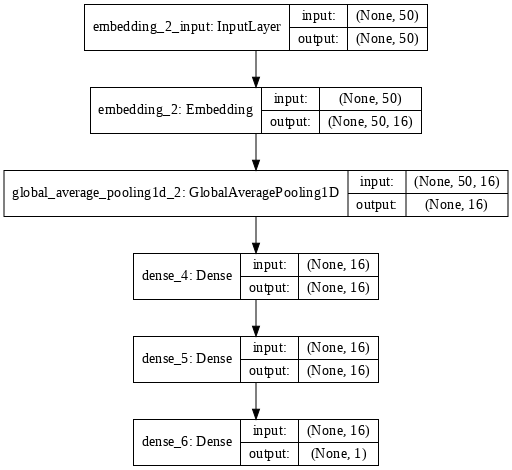

In [34]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=72)

### Training Run

In [35]:
### Parameters ###
batch_size = 256 #@param {type:"integer"}
epochs = 4 #@param {type:"slider", min:0, max:100, step:1}
validation_split = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}
###            ###

history = model.fit(x=train_data,
                    y=train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1)

ValueError: ignored

In [ ]:
# Evaluation Phase
results = model.evaluate(test_data, test_labels)
print()

for i in range(len(model.metrics_names)):
    if model.metrics_names[i] == "acc":
        print(f"Metric - {model.metrics_names[i]}: {results[i]*100:.3f}")
    else:
        print(f"Metric - {model.metrics_names[i]}: {results[i]}")  

if multiclass == False: 
    predictions = [1 * (x[0]>=0.5) for x in model.predict(test_data)]
    cm = confusion_matrix(test_labels, predictions)
else:    
    predictions = np.argmax(model.predict(test_data), axis=1)
    cm = confusion_matrix(test_labels.argmax(axis=1), predictions)
print()
print(cm)

heatmap(cm, fmt="g", annot=True, square=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Model Analysis

### Model Analysis: Out-of-Vocabulary (OOV) words in Embeddings

Obviously, assigning all OOV words the same "UNK" vector will decrease performance [[1](https://stackoverflow.com/questions/45495190/initializing-out-of-vocabulary-oov-tokens)].

Other ideas:
- Simply remove all OOV words; too high time complexity.
- Assign the average of its surrounding words [[2](https://stackoverflow.com/questions/41517969/how-to-get-random-word2vec-vector-for-unknow-word)], but that would require running through the entire dataset and performing calculations, thus too high time complexity.
- Assign a unique random vector (uniform -0.5 to 0.5) to each word  [[1](https://stackoverflow.com/questions/45495190/initializing-out-of-vocabulary-oov-tokens)].

| Approach (Using LSTM, 10 epochs) | Trainable On/Off | Performance |
| - | - | - | 
| Pretrained, All OOV words set to a vector of zeros | False | 85.420 |
| Pretrained, All OOV words set to a vector of zeros | True | 87.500 |
| Pretrained, Each OOV word set to a unique random vector | False | 84.608 |
| Pretrained, Each OOV word set to a unique random vector | True | 87.568 |
| My own custom Word2Vec and use random vectors for OOV | False | 86.004 |
| My own custom Word2Vec and use random vectors for OOV | True | 87.612 |

### Model Analysis: **Overfitting**

In [ ]:
def plot_model_history():
    plt.clf()  # clear figure

    plt.style.use('ggplot')

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

print(history.history.keys())    
plot_model_history()

After a certain number of Epochs the line continues to improve for the training data but does not for the validation data. This is a result of **overfiting**. After that point, the model over-optimizes and learns representations specific to the training data.

We should simply stop training after a certain epoch. To prevent overfitting, the best solution is to use more training data or reduce the number of parameters (capacity). A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization - two common such techniques are weight regularization and dropout. Concluding, the most common way to prevent overfitting are:
- Get more training data.
- Reduce the capacity of the network.
- Add weight regularization.
- Add dropout.

## Comparative Analysis of Parameters

### Preprocessing Parameters

Manually change the parameter at hand and note down the resulting accuracy. 
Remember that we can't use the test set since it is considered cheating (data leak). However, the parameters tested here are of very general scope so we will use the test set anyway. The following neural network structure was used:

```
elif embeddings_mode == "One-hot Encoding":
    model = keras.Sequential()
    model.add(Embedding(input_dim=feature_count, output_dim=16, input_length=embeddings_sequence_length))  
    model.add(CuDNNLSTM(units=neurons))
    model.add(Dropout(0.1, seed=random_state)) 
    ...
    
validation_split = 0.1
```

| Feature Count | Performance |
| - | - |
| 5000 | 86.456 |
| 10000 | 87.048 |
| 20000 | 86.868 |
| 30000 | 86.504 |

| Feature Count (Big Seq Length) | Performance |
| - | - |
| 10000 | 86.708 |
| 20000 | 87.004 |
| 30000 | 86.812 |

| Embeddings Sequence Length | Performance |
| - | - |
| 64 | 81.88 |
| 128 | 85.28 |
| 256 | 87.388 |
| 512 | 85.896 |

| Remove First | Performance |
| - | - |
| True | 0.8664 |
| False | 0.8691 |

### **Model** Parameters (Grid Search) 

Use GridSearchCV to automatically try all possible parameters combinations. Remember that we can't use the test set since it is considered cheating (data leak).

| Parameter | Values | Best Performing |
| - | - | - |
| Batch Size | batch_size = [32, 64, 128, 256, 512, 1024] | (useless benchmark) curve with 128 being the peak, high deviation, big drop off at large values |
| Epochs | epochs = [1, 2, 3, 5, 10] | (useless benchmark) curve with 3 being the peak |
| Validation Set Split | validation_split = [0.0, 0.1, 0.25, 0.5] | the lower the better, 0.1 performs best |
| Neurons | neurons = [8, 16, 32, 64] | the higher the better |
| Embeddings Initializer | init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'] | 'uniform' 'normal' 'glorot_normal' 'he_normal' 'he_uniform' |
| Activation Function | activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'] | 'linear' 'relu' 'tanh' 'softsign'|
| Optimizer | optimizer = ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adamax', 'Nadam'] | 'Adam' 'Adagrad' 'Adamax' |

Some General Information [[1](https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/)]:

| Problem type | Last-layer activation | Loss function | Example |
| - | - | - | - |
| Binary classification | sigmoid | binary_crossentropy | Dog vs. cat, Sentiment analysis |
| Multi-class, single-label classification | softmax | categorical_crossentropy | MNIST |
| Multi-class, multi-label classification | sigmoid | binary_crossentropy | News tags classification, one blog can have multiple tags |
| Regression to arbitrary values | None | mse | Predict house price (an integer/float) |
| Regression to values between 0 and 1 | sigmoid | mse or binary_crossentropy | Engine health assessment where 0 is broken, 1 is new |

In [ ]:
### Parameters ###
run_this_section = False #@param {type:"boolean"}
###            ###

if run_this_section == True:
    from keras.wrappers.scikit_learn import KerasClassifier
    from sklearn.model_selection import GridSearchCV

    def create_model(neurons=16, init_mode='uniform', activation='relu', optimizer='Adam'):
        model = Sequential()
        model.add(Embedding(input_dim=feature_count, output_dim=16, input_length=embeddings_sequence_length))  
        model.add(CuDNNLSTM(units=neurons))  # CuDNNLSTM: Tensorflow's default LSTM is awful at utilizing GPU/parallelization, [1] https://stackoverflow.com/a/47610747, [2] https://news.ycombinator.com/item?id=14538086
        model.add(Dropout(0.1, seed=random_state))
        model.add(Dense(units=neurons, activation=activation, use_bias=True))
        model.add(Dense(1, activation='sigmoid'))  # the value of 1 doesn't refer to the neuron count, e.g. for multi-class it refers to the number of categories

        model.compile(optimizer='Adam',
                      #optimizer=keras.optimizers.Adam(lr=lr),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])   
        return model

    param_grid = dict(batch_size = [128],
                      epochs = [10],
                      validation_split = [0.0],
                      #neurons = [8, 16, 32, 64],
                      #init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
                      #activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
                      #kernel_constraint = [1, 2, 3, 4, 5],
                      #optimizer = ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adamax', 'Nadam'],
                      #lr = [0.01, 0.001, 0.0005]
                     )

    # Make use of Keras' scikit-learn API, also supports the parameters of the 'fit', 'predict', 'predict_proba', and 'score' methods
    model = KerasClassifier(build_fn=create_model, verbose=0)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, verbose=1, n_jobs=-1)  # Where 'cv' is the number of cross-validation folds

    grid_result = grid.fit(train_data, train_labels)

    print(f"\n- - - - - BEST PARAMETERS - - - - -")
    print(f"{grid_result.best_score_:.8f} using {grid_result.best_params_}")

    print(f"\n- - - - - DETAILS - - - - -")
    for i in range(len(grid_result.cv_results_['params'])):         
        print(f"mean - {grid_result.cv_results_['mean_test_score'][i]:.10f}; std - {grid_result.cv_results_['std_test_score'][i]:.10f} - {grid_result.cv_results_['params'][i]}")

## Advanced Code


### Code

In [36]:
# Adam print the weights when using decay
def adam_weights_calculator(epochs=5):
    '''
        Prints the learning rate per epoch when using decay
    '''
    for i in range(epochs):
        beta_1 = 0.9 
        beta_2 = 0.999
        lr = 0.001
        decay = 0.01

        lr = lr * (1. / (1. + decay * i))
        t = i + 1
        lr_t = lr * math.sqrt(1. - math.pow(beta_2, t)) / (1. - math.pow(beta_1, t))
        print(f"Adam LR on epoch {i+1}: {lr_t:.6f}")

adam_weights_calculator(5)

Adam LR on epoch 1: 0.000316
Adam LR on epoch 2: 0.000233
Adam LR on epoch 3: 0.000198
Adam LR on epoch 4: 0.000178
Adam LR on epoch 5: 0.000166


In [37]:
# For Multi-class tasks in particular, the following changes need to be performed
# 1. Dense(1), the value of 1 on the final layer refers to the number of categories
# 2. activation = "softmax"
# 3. loss = "categorical_crossentropy" https://stackoverflow.com/a/46038271

#model.add(CuDNNLSTM(units=128))  # CuDNNLSTM: Tensorflow's default LSTM is awful at utilizing GPU/parallelization, [1] https://stackoverflow.com/a/47610747, [2] https://news.ycombinator.com/item?id=14538086

model = Sequential()
model.add(Embedding(input_dim=feature_count, output_dim=100, input_length=embeddings_sequence_length))  
#model.add(Embedding(input_dim=feature_count, output_dim=embeddings_dimension, weights=[embedding_vectors], input_length=embeddings_sequence_length, trainable=trainable))
#model.add(Dropout(0.2, seed=random_state))  # Maybe remove the seed since it makes it biased
#model.add(Conv1D(filters=250, kernel_size=3, padding='valid', activation='relu', strides=1))
#model.add(GlobalAveragePooling1D())
#model.add(Flatten())
model.add(CuDNNLSTM(units=128, return_sequences=True))
model.add(CuDNNLSTM(units=128, return_sequences=True))
#model.add(MultiplicativeLSTM(units=128))
model.add(CuDNNLSTM(units=128))
#model.add(Flatten())
#model.add(BatchNormalization())
#model.add(CuDNNLSTM(units=60, kernel_regularizer=keras.regularizers.l2(0.00001)))
model.add(Dropout(0.5, seed=random_state))  
#model.add(Dense(units=128, activation='relu', use_bias=True))
#model.add(Dense(units=128, activation='relu', use_bias=True))
#model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.summary()

model.compile(#optimizer=Adagrad(lr=0.005),
              optimizer=Adam(lr=0.00005),  # 0.0005 or even better 0.00005
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', baseline=0.90, patience=3, verbose=1)
model_save = ModelCheckpoint('./gdrive/My Drive/Colab Saved Models/best_model_text.h5', monitor='val_loss', mode='min', save_best_only=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           1500000   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 50, 128)           117760    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 50, 128)           132096    
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387       
Total params: 1,882,339
Trainable params: 1,882,339
Non-trainable params: 0
____________________________________________

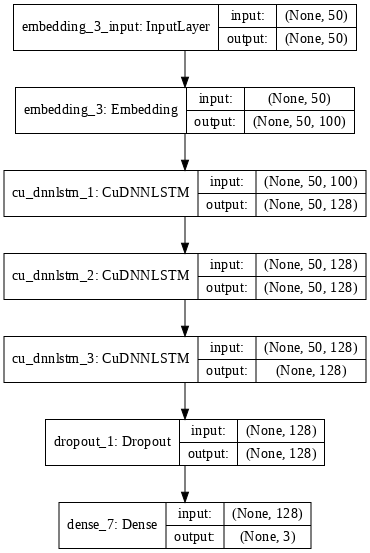

In [38]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=72)

In [39]:
# Training Phase
history = model.fit(x=train_data,
                    y=train_labels,
                    batch_size=128,
                    epochs=20,
                    validation_data=(test_data, test_labels),  
                    # The above isn't really "cheating", it's the equivalent of trying different parameters manually till we find the best for the specific  
                    # model we are building like research papers do.
                    #validation_split=0.1,
                    callbacks=[early_stop, model_save],
                    verbose=1)

model = load_model('./gdrive/My Drive/Colab Saved Models/best_model_text.h5')
#model = load_model('best_model_text.h5', custom_objects={'MultiplicativeLSTM': MultiplicativeLSTM})  # Handling saved models changes if we are using custom (3rd-party) layers


Train on 48213 samples, validate on 5357 samples
Epoch 1/20
48213/48213 [==============================] - 13s 266us/step - loss: 1.0246 - accuracy: 0.4455 - val_loss: 0.9927 - val_accuracy: 0.4650
Epoch 2/20
48213/48213 [==============================] - 6s 124us/step - loss: 0.9141 - accuracy: 0.5466 - val_loss: 0.8501 - val_accuracy: 0.5985
Epoch 3/20
48213/48213 [==============================] - 6s 123us/step - loss: 0.7919 - accuracy: 0.6333 - val_loss: 0.8106 - val_accuracy: 0.6190
Epoch 4/20
48213/48213 [==============================] - 6s 124us/step - loss: 0.7325 - accuracy: 0.6674 - val_loss: 0.8020 - val_accuracy: 0.6289
Epoch 5/20
48213/48213 [==============================] - 6s 122us/step - loss: 0.6846 - accuracy: 0.6962 - val_loss: 0.8073 - val_accuracy: 0.6300
Epoch 6/20
48213/48213 [==============================] - 6s 123us/step - loss: 0.6475 - accuracy: 0.7155 - val_loss: 0.8133 - val_accuracy: 0.6377
Epoch 7/20
48213/48213 [==============================] - 6s 

5357/5357 [==============================] - 1s 191us/step

Metric of the best model - loss: 0.8020134239315163
Metric of the best model - accuracy: 0.6288967728614807

[[ 296  335  160]
 [ 197 1601  693]
 [  64  539 1472]]


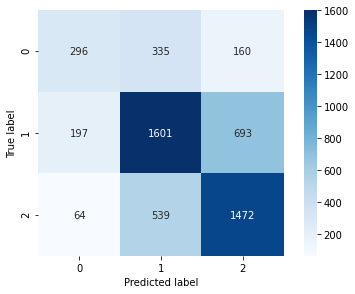

In [40]:
# Evaluation Phase
results = model.evaluate(test_data, test_labels)
print()

for i in range(len(model.metrics_names)):
    if model.metrics_names[i] == "acc":
        print(f"Metric of the best model - {model.metrics_names[i]}: {results[i]*100:.3f}")
    else:
        print(f"Metric of the best model - {model.metrics_names[i]}: {results[i]}")  

if multiclass == False: 
    predictions = [1 * (x[0]>=0.5) for x in model.predict(test_data)]
    cm = confusion_matrix(test_labels, predictions)
else:    
    predictions = np.argmax(model.predict(test_data), axis=1)
    cm = confusion_matrix(test_labels.argmax(axis=1), predictions)
print()
print(cm)

heatmap(cm, fmt="g", annot=True, square=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show() 

### Comparative Analysis of different Neural Networks

General Good Settings: feature_count=15000, embeddings_sequence_length=50, batch_size=256, epochs=5.

* My Parameters for IMDb Dataset (average length of instance is 238, max is 2494): random_state=22, feature_count=20000, remove_first=False, embeddings_mode=Word2Vec Pretrained, embeddings_sequence_length=256, Each OOV word set to a unique random vector, trainable=True, batch_size=256, epochs=EarlyStopping, activation=sigmoid, optimizer='adam', learning_rate=0.00005, validation_split=0.0, neurons=128.

* My Parameters For Subjectivity Dataset (average length of instance is 21.5, max is 111): Obviously we want a significantly shorter sequence length, a bit smaller batch size and a higher learning rate since the nature of the dataset is very different the the IMDb one. embeddings_sequence_length=32, batch_size=128, learning_rate=0.0001.

* My Parameters For Polarity Dataset (average length of instance is 18.8, max is 51): Obviously we want a significantly shorter sequence length, a bit smaller batch size and a higher learning rate since the nature of the dataset is very different the the IMDb one. embeddings_sequence_length=32, batch_size=128, learning_rate=0.00005.

It is worth noting that the results are kind of random/useless because of the small size of the dataset as well as the fast convergence. Obviously, here we train different models on different number of epochs instead of comparing a set of models on the same number of epochs.

| Model | Author | Performance (loss /acc) | Epochs | Embeddings Dimension | Note |
| - | - | - | - | - | - |
| Single LSTM | Me | 0.341 / 86.052 | 11 | 100 | This is run with One-hot Encoding - It reaches convergence too fast for Dropout or Deep to matter |
| Single LSTM with Dropout | Me | 0.339 / 86.556 | 8 | 100 | This is run with One-hot Encoding |
| Deep Stacked LSTMs with Dropout | Me | 0.346 / 85.188 | 4 | 100 | This is run with One-hot Encoding |
| Multilayer Perceptron | Me | 0.294 / 87.708 | 17 | 300 | Now we move to Word2Vec Pretrained |
| Multilayer Perceptron with Average Pooling | Me | 0.287 / 88.404 | 29 | 300 | - |
| Single LSTM | Me | 0.303 / 87.240 | 9 | 300 | - |
| Single LSTM with Dropout | Me | 0.307 / 87.048 | 12 | 300 | - |
| Bidirectional LSTM | Me | 0.297 / 87.456 | 10 | 300 | - |
| Bidirectional LSTM with Dropout | Me | 0.312 / 86.828 | 9 | 300 | - |
| Deep Stacked LSTMs  | Me | 0.326 / 86.396 | 8 | 300 | - |
| Deep Stacked LSTMs with Dropout | Me | 0.327 / 86.938 | 11 | 300 | - |
| Simple RNN | Me | 0.342 / 85.844 | 12 | 300 | - |
| Bidirectional Simple RNN | Me | 0.344 / 85.640 | 14 | 300 | - |
| GRU | Me | 0.298 / 87.776 | 7 | 300 | - |
| GRU with Dropout | Me | 0.298 / 87.572 | 11 | 300 | - |
| CNN with Average Pooling | Me | 0.286 / 88.424 | 4 | 300 | lr=0.0005 |
| LSTM inspired from Paper | [Liu et al.](https://aclweb.org/anthology/D15-1280) | 0.281 / 88.544 | 1 | 300 | We use the exact parameters from the paper with batch_size=128 and lr=0.05. Paper's accuracy: 88.50 |
| mLSTM inspired from Paper | [Krause et al.](https://arxiv.org/pdf/1609.07959.pdf) | 0.356 / 87.84 | 4 | 300 | (Useless since we lack processing power)) We use similar parameters to those from the paper but no dropout, units=128, batch_size=512. [Code](https://github.com/titu1994/Keras-Multiplicative-LSTM). Paper's accuracy: - |
| mLSTM inspired from Paper | [Krause et al.](https://arxiv.org/pdf/1609.07959.pdf) | 0.320 / 85.95 | 4 | 300 | (Useless since we lack processing power) We don't perform all the extra things the paper does, units=1000, batch_size=512. Paper's accuracy: - |

| Model (on just 1 fold of cross_val) | Author | Performance | Epochs | Embeddings Dimension | Note |
| - | - | - | - | - | - |
| Single LSTM | Me | 90.400 | 7 | 100 | This is run with One-hot Encoding - It reaches convergence too fast for Dropout or Deep to matter |
| Single LSTM with Dropout | Me | 90.400 | 9 | 100 | This is run with One-hot Encoding |
| Deep Stacked LSTMs with Dropout | Me | 89.500 | 6 | 100 | This is run with One-hot Encoding |
| Multilayer Perceptron | Me | 91.400 | 8 | 300 | Now we move to Word2Vec Pretrained |
| Multilayer Perceptron with Average Pooling | Me | 92.300 | 10 | 300 | - |
| Single LSTM | Me | 90.400 | 6 | 300 | - |
| Single LSTM with Dropout | Me | 90.900 | 6 | 300 | - |
| Bidirectional LSTM | Me | 90.500 | 5 | 300 | - |
| Bidirectional LSTM with Dropout | Me | 90.200 | 5 | 300 | - |
| Deep Stacked LSTMs  | Me | 90.400 | 4 | 300 | - |
| Deep Stacked LSTMs with Dropout | Me | 90.700 | 6 | 300 | - |
| Simple RNN | Me | 89.200 | 7 | 300 | - |
| Bidirectional Simple RNN | Me | 90.300 | 7 | 300 | - |
| GRU | Me | 90.800 | 7 | 300 | - |
| GRU with Dropout | Me | 91.200 | 7 | 300 | - |
| CNN with Average Pooling | Me | 91.700 | 14 | 300 | lr=0.0005 |
| LSTM inspired from Paper | [Liu et al.](https://aclweb.org/anthology/D15-1280) | 91.100 | 1 | 300 | We use the exact parameters from the paper with units=60, batch_size=128 and lr=0.05. Paper's accuracy: - |
| mLSTM inspired from Paper | [Krause et al.](https://arxiv.org/pdf/1609.07959.pdf) | 91.900 | 3 | 300 | (Useless since we lack processing power)) We use similar parameters to those from the paper but no dropout, units=128, batch_size=512. [Code](https://github.com/titu1994/Keras-Multiplicative-LSTM). Paper's accuracy: - |
| mLSTM inspired from Paper | [Krause et al.](https://arxiv.org/pdf/1609.07959.pdf) | 90.000 | 4 | 300 | (Useless since we lack processing power) We don't perform all the extra things the paper does, units=1000, batch_size=128. Paper's accuracy: - |

| Model (on just 1 fold of cross_val) | Author | Performance | Epochs | Embeddings Dimension | Note |
| - | - | - | - | - | - |
| Single LSTM | Me | 72.352 | 8 | 100 | This is run with One-hot Encoding - It reaches convergence too fast for Dropout or Deep to matter |
| Single LSTM with Dropout | Me | 72.638 | 10 | 100 | This is run with One-hot Encoding |
| Deep Stacked LSTMs with Dropout | Me | 71.516 | 7 | 100 | This is run with One-hot Encoding |
| Multilayer Perceptron | Me | 77.226 | 14 | 300 | Now we move to Word2Vec Pretrained |
| Multilayer Perceptron with Average Pooling | Me | 78.257 | 13 | 300 | - |
| Single LSTM | Me | 77.130 | 8 | 300 | - |
| Single LSTM with Dropout | Me | 75.351 | 6 | 300 | - |
| Bidirectional LSTM | Me | 78.913 | 5 | 300 | - |
| Bidirectional LSTM with Dropout | Me | 76.859 | 7 | 300 | - |
| Deep Stacked LSTMs  | Me | 72.541 | 1 | 300 | - |
| Deep Stacked LSTMs with Dropout | Me | 72.259 | 4 | 300 | - |
| Simple RNN | Me | 75.914 | 11 | 300 | - |
| Bidirectional Simple RNN | Me | 73.482 | 8 | 300 | - |
| GRU | Me | 78.163 | 8 | 300 | - |
| GRU with Dropout | Me | 78.738 | 12 | 300 | - |
| CNN with Average Pooling | Me | 79.007 | 17 | 300 | lr=0.0005 |
| LSTM inspired from Paper | [Liu et al.](https://aclweb.org/anthology/D15-1280) | 79.663 | 2 | 300 | We use the exact parameters from the paper with units=60, batch_size=128 and lr=0.005. Paper's accuracy: - |
| mLSTM inspired from Paper | [Krause et al.](https://arxiv.org/pdf/1609.07959.pdf) | 80.506 | 2 | 300 | (Useless since we lack processing power)) We use similar parameters to those from the paper but no dropout, units=128, batch_size=512. [Code](https://github.com/titu1994/Keras-Multiplicative-LSTM). Paper's accuracy: - |
| mLSTM inspired from Paper | [Krause et al.](https://arxiv.org/pdf/1609.07959.pdf) | 78.164 | 7 | 300 | (Useless since we lack processing power) We don't perform all the extra things the paper does, units=1000, batch_size=128. Paper's accuracy: - |

## Evaluate on External Data

### Preprocessing Run

FIRST, execute the entire preprocessing phase again (there are more efficient ways, but this works universally).

In [41]:
###   INPUT    ###
test_sentence = ["very bad movie, wow awful such a bad performance from the actors."]
###            ###

### Parameters ###
remove_first = False #@param {type:"boolean"}
embeddings_mode = "One-hot Encoding" #@param ["One-hot Encoding", "Tokenizing", "Word2Vec Pretrained", "Word2Vec Training"]
embeddings_sequence_length = 50 #@param {type:"integer"}
trainable = False #@param {type:"boolean"}
outofvocab_mode = "random" #@param ["zeros", "random"]
###            ###

# Load Dataset
train_data, test_data, train_labels, test_labels = load_dataset()
print_dataset_length_stats(train_data)

# Remove the <START> symbol from all instances
if remove_first == True:
    if train_data[0][0] == word_index["<START>"]:
        for i in range(len(train_data)):
            train_data[i] = train_data[i][1:]
        for i in range(len(test_data)):
            test_data[i] = test_data[i][1:]

# Create the Embeddings            
if embeddings_mode == "One-hot Encoding":  
    ''' 
        ONE-HOT ENCODING
        Description: Not traditional One-hot, but instead [3, 62, 5, 90, ...] 
        Embedding_Layer: Yes
    '''   
    if dataset_name != "IMDb Large Movie Review Dataset":  # keras.imdb is already One-hot Encoded
        tokenizer = Tokenizer(num_words=feature_count, 
                              lower=True, 
                              split=' ', 
                              oov_token="<UNK>")
        tokenizer.fit_on_texts(train_data)
        # 'texts_to_sequences' list of strings as input and sequence of integers as output, 'texts_to_matrix' is meant to return a matrix of counts/tf-idfs
        train_data = tokenizer.texts_to_sequences(train_data)
        test_data = tokenizer.texts_to_sequences(test_data)  
    
    # Word_Index Stuff
    if dataset_name == "IMDb Large Movie Review Dataset":  # keras.imdb is already One-hot Encoded
        word_index, reverse_word_index = imdb_specific_word_index()
    else:
        word_index, reverse_word_index = other_datasets_word_index(tokenizer)

    word_index, reverse_word_index = reduce_word_index_features(word_index, reverse_word_index, train_data)  # Update the word index to match the number of features we selected       

    # NEW
    test_sentence = encode_review(test_sentence[0], word_index)
    test_sentence = np.array([test_sentence])  # Convert back to 2D array even if there is no use yet

    # Peform Sequence Padding
    train_data, test_data = sequence_padding(train_data, test_data, embeddings_sequence_length)
    # NEW
    test_sentence, _ = sequence_padding(test_sentence, test_sentence, embeddings_sequence_length) 

elif embeddings_mode == "Tokenizing":  
    ''' 
        TOKENIZING
        Description: Unlike other modes this isn't exactly an embedding, leads to a collection of floats [0.00, 0.02, 0.12, 0.04, ...] based on tf-idf 
        Embedding_Layer: No
    '''    
    if dataset_name == "IMDb Large Movie Review Dataset":  # keras.imdb is already One-hot Encoded so let's transform it back to text
        word_index, reverse_word_index = imdb_specific_word_index()
        train_data = [decode_review(instance, reverse_word_index, mode="join") for instance in train_data]
        test_data = [decode_review(instance, reverse_word_index, mode="join") for instance in test_data]
    
    tokenizer = Tokenizer(num_words=feature_count, 
                          lower=True, 
                          split=' ', 
                          )
    tokenizer.fit_on_texts(train_data)
    # 'texts_to_matrix' list of strings as input, 'sequences_to_matrix' list of integer word indices as input 
    train_data = tokenizer.texts_to_matrix(train_data, mode='tfidf')
    test_data = tokenizer.texts_to_matrix(test_data, mode='tfidf')

     # NEW
    test_sentence = tokenizer.texts_to_matrix(test_sentence, mode='tfidf')
  
elif embeddings_mode == "Word2Vec Pretrained":
    ''' 
        WORD2VEC PRETRAINED
        Description: A much more advanced form of embeddings that is created through training a model unlike previous modes. Implements the CBOW and the Skip-gram models in order to learn word embeddings.
        Embedding_Layer: Yes
    '''
    word2vec = load_word2vec_pretrained()  # This line can be commented out, if it was already loaded in the current session
    embeddings_dimension = word2vec.vector_size
    
    if dataset_name != "IMDb Large Movie Review Dataset":  # keras.imdb is already One-hot Encoded
        tokenizer = Tokenizer(num_words=feature_count, 
                              lower=True, 
                              split=' ', 
                              oov_token="<UNK>")
        tokenizer.fit_on_texts(train_data)
        # 'texts_to_sequences' list of strings as input and sequence of integers as output, 'texts_to_matrix' is meant to return a matrix of counts/tf-idfs
        train_data = tokenizer.texts_to_sequences(train_data)
        test_data = tokenizer.texts_to_sequences(test_data)   
    
    # Word_Index Stuff
    if dataset_name == "IMDb Large Movie Review Dataset":  # keras.imdb is already One-hot Encoded
        word_index, reverse_word_index = imdb_specific_word_index()
    else:
        word_index, reverse_word_index = other_datasets_word_index(tokenizer)

    word_index, reverse_word_index = reduce_word_index_features(word_index, reverse_word_index, train_data)  # Update the word index to match the number of features we selected       

    # NEW
    test_sentence = encode_review(test_sentence[0], word_index)
    test_sentence = np.array([test_sentence])  # Convert back to 2D array even if there is no use yet

    # Peform Sequence Padding  
    train_data, test_data = sequence_padding(train_data, test_data, embeddings_sequence_length)
    # NEW
    test_sentence, _ = sequence_padding(test_sentence, test_sentence, embeddings_sequence_length)  

    manage_oov_words(word2vec, word_index)
    embedding_vectors = assign_embeddings(word2vec, embeddings_dimension, word_index, mode=outofvocab_mode)

elif embeddings_mode == "Word2Vec Training":
    ''' 
        Description: A much more advanced form of embeddings that is created through training a model unlike previous modes. Implements the CBOW and the Skip-gram models in order to learn word embeddings.
        Embedding_Layer: Yes
    '''
    if dataset_name != "IMDb Large Movie Review Dataset":  # keras.imdb is already One-hot Encoded so let's transform it back to text
        tokenizer = Tokenizer(num_words=feature_count, 
                              lower=True, 
                              split=' ', 
                              oov_token="<UNK>")
        tokenizer.fit_on_texts(train_data)
        # 'texts_to_sequences' list of strings as input and sequence of integers as output, 'texts_to_matrix' is meant to return a matrix of counts/tf-idfs
        train_data = tokenizer.texts_to_sequences(train_data)
        test_data = tokenizer.texts_to_sequences(test_data)  
        
    # Word_Index Stuff
    if dataset_name == "IMDb Large Movie Review Dataset":  # keras.imdb is already One-hot Encoded so let's transform it back to text
        word_index, reverse_word_index = imdb_specific_word_index()
    else:
        word_index, reverse_word_index = other_datasets_word_index(tokenizer)

    word_index, reverse_word_index = reduce_word_index_features(word_index, reverse_word_index, train_data)  # Update the word index to match the number of features we selected       
      
    # Train a Model
    time_counter = time.time()    
    print(f"\nTraining a new custom Word2Vec model on the dataset...")
    word2vec = Word2Vec([decode_review(instance, reverse_word_index, mode="don't join") for instance in train_data],  # Default is 5 epochs 
                         size=300, sg=0, window=5, min_count=1, iter=5,
                         seed=random_state, alpha=0.025, workers=4)
    embeddings_dimension = word2vec.wv.vector_size
    print(f"Training completed in {time.time()-time_counter:.2f}sec. Vocabulary size: {len(word2vec.wv.vocab)}\n")  

    # Peform Sequence Padding  
    train_data, test_data = sequence_padding(train_data, test_data, embeddings_sequence_length) 
    
    manage_oov_words(word2vec.wv, word_index)   
    embedding_vectors = assign_embeddings(word2vec.wv, embeddings_dimension, word_index, mode=outofvocab_mode)    
    
    # If we want to store the model
    if False:
        model.wv.save_word2vec_format("My_Word2Vec.txt", binary=False)    

# Print the resulting instances       
for i in range(4): print(type(train_data[i]), list(train_data[i]))

Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/sms-2013test-A.tsv
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/livejournal-2014test-A.tsv
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/twitter-2016devtest-A.txt
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/twitter-2016dev-A.txt
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/twitter-2016train-A.txt
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/twitter-2013dev-A.txt
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/twitter-2013test-A.txt
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/twitter-2013train-A.txt
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEval-2017 Task 4/GOLD/Subtask_A/twitter-2014test-A.txt
Loaded Subset ./gdrive/My Drive/Colab Datasets/SemEv

Decide on a final embeddings mode out of the 4. Then the above code can be run once at the start, and a different code can be run each time for a prediction.

### Code

In [42]:
# Load Model
model = load_model('./gdrive/My Drive/Colab Saved Models/best_model_text.h5')
#model = load_model('best_model_text.h5', custom_objects={'MultiplicativeLSTM': MultiplicativeLSTM})  # Handling saved models changes if we are using custom (3rd-party) layers

In [44]:
# Evaluation Phase
def evaluate_single_sentence(model, test_sentence, multiclass):
    if multiclass == False: 
        probability = model.predict(test_sentence)
        predictions = [1 * (x[0]>=0.5) for x in probability]  

        # 0 stands for negative, 1 stands for positive
        if predictions[0] == 1:
            return ("positive", probability) 
        elif predictions[0] == 0:
            return ("negative", probability)
        else:
            return ("no prediction", None)

    else:    
        probability = model.predict(test_sentence)
        predictions = np.argmax(probability, axis=1)
    
        # 0 stands for negative, 1 stands for neutral, 2 stands for positive
        if predictions[0] == 2:
            return ("positive", probability) 
        elif predictions[0] == 1:
            return ("neutral", probability)
        elif predictions[0] == 0:
            return ("negative", probability)            
        else:
            return ("no prediction", None)        

print(evaluate_single_sentence(model, test_sentence, multiclass))

('negative', array([[0.5037171 , 0.25885844, 0.23742439]], dtype=float32))
